# Getting risk insights on Tornados with Spark on IBM Db2
### Visual analysis of tornado records in the USA for risk assessment


This notebook shows you how to use IBM Db2 Warehouse to efficiently handle, analyze and visualize geographic data with Spark. It provides you with the tools to launch your own Spark application with IBM Db2 Warehouse.
You will learn how to connect to Db2, launch a Spark application, load data from Db2 and manipulate dataframes. 

Our present use case is tornados in the USA and a potential industrial application of this use case is tailored insurance policy making. Based on the history of tornados in the region of your insurance holders, predict how likely they are to encounter a natural disaster and adapt their policy according to the risk they really face.

This notebook runs with a PySpark kernel. Visualizations are outputed locally.

#### Contents 

[1. Configure your resources](#imports)

[2. Load the data](#load_tornado)

[3. Explore the data](#explore_tornado)
* [a. Overview: repartition of tornados in the US](#overview)
* [b. Heat map: get insights in the hotspots](#heatmap)
* [c. Density map per state: identify where the risk hide](#density_map)

[4. Machine Learning: Tornado Clustering](#ML)
* [a. Build tornado clusters in Texas](#clusters_texas)
* [b. Assess risk for home insurance holders in Texas](#insurance_holders)

[5. Deploy your own application](#you)

<a id="imports"></a>
## 1. Configure your resources 

#### Configure Livy 

Please refer to the steps described in README.md (dashdb_analytic_tools/dashdblocal_notebooks/livy-notebooks/README.md). 

#### Start a Spark session

In [2]:
import org.apache.spark.ml.linalg.{Vector, Vectors}
import org.apache.spark.sql.SQLContext
import org.apache.spark.SparkConf
import org.apache.spark.SparkContext
import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.types.DoubleType
import org.apache.spark.sql.types.StructType
import org.apache.spark.sql.types.StructField
import org.apache.spark.sql.Row
import org.apache.spark.sql.types.IntegerType
import java.sql.Connection
import java.sql.SQLException
import java.sql.ResultSet
import java.sql.Statement
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.clustering.KMeansModel
import org.apache.spark.ml.feature.VectorAssembler

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
66,None,spark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.ml.linalg.{Vector, Vectors}
import org.apache.spark.sql.SQLContext
import org.apache.spark.SparkConf
import org.apache.spark.SparkContext
import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.types.DoubleType
import org.apache.spark.sql.types.StructType
import org.apache.spark.sql.types.StructField
import org.apache.spark.sql.Row
import org.apache.spark.sql.types.IntegerType
import java.sql.Connection
import java.sql.SQLException
import java.sql.ResultSet
import java.sql.Statement
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.clustering.KMeansModel
import org.apache.spark.ml.feature.VectorAssembler


#### Connect with bludb user

The following cell uses ibmdbpy library to establish a connection from this notebook to the bludb database. The cell prepares the input data based on sample tables that are available in every Db2 Warehouse container out of the box. You can run this notebook against any bludb instance that you have available. But when the cell runs for the first time the setup can take a couple of minutes.

Here we check if the tables containing data about tornados and home insurance holders have already created, if not we build them.

In [3]:
//NOT-FOR-APP
import java.sql.DriverManager
import java.sql.Connection
val connection = DriverManager.getConnection("jdbc:db2:BLUDB")
try {   
    val statement = connection.createStatement()
    statement.executeUpdate("create table tornado as ( " +
         " select objectid,yr,mo,dy, time, cast(slat as float) as slat,cast(slon as float) as slon, " +
         "        elat,elon,cast (len as float) as len,cast(wid as float) as wid,st,cast(mag as float) as mag " +
         " from samples.geo_tornado ) with data")
} catch {
    case e: SQLException => { if (e.getErrorCode() == -601) println("Table TORNADO already exists") else throw e }
}
try {   
    val statement = connection.createStatement()
    statement.executeUpdate("create table texas_customers as ( " +
         " select b.objectid, b.name, b.insurance_value, db2gse.st_x(b.shape) lon, db2gse.st_y(b.shape) lat " +
         "     from samples.geo_county a, samples.geo_customer b " +
         "     where a.statefp='48' and db2gse.st_within(b.shape, a.shape) = 1 " +
         " ) with data")
} catch {
    case e: SQLException => { if (e.getErrorCode() == -601) println("Table TEXAS_CUSTOMERS already exists") else throw e }
}
connection.close()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import java.sql.DriverManager
import java.sql.Connection
connection: java.sql.Connection = com.ibm.db2.jcc.uw.UWConnection@1240f25
Table TORNADO already exists
res9: AnyVal = ()
Table TEXAS_CUSTOMERS already exists
res10: AnyVal = ()


#### Local imports for visualization

Note : check if you have magics with __%%help__. Here you need __%%local__ and __%%sql__.

In order to display the plots within this notebook, we use __%matplotlib inline__. If you like to display the images in separate windows, just comment out this line.

In [4]:
%%local
%matplotlib inline

import pandas as pd
import numpy as np
import geopandas 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy import ndimage
import matplotlib.pylab as pylab

## 2. Load the data

Read the training data using the IDAX data source. In case of dashDB MPP systems this will give us
automatically a DataFrame with exactly the number of partitions as there are MLNs (database partitions)
in dashDB and the DataFrame partitions will be located in each according executor colocated with the
dashDB MLN.

In [5]:
var input = spark.read.
   format("com.ibm.idax.spark.idaxsource").
   option("dbtable", "TORNADO").
   load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

input: org.apache.spark.sql.DataFrame = [OBJECTID: int, YR: string ... 11 more fields]


The input data are all recorded tornados in USA between 1950 and 2013. It is taken from http://www.spc.noaa.gov/.

When this demo is run with a dashDB SMP system (i.e. non partitioned databse) the next step should be run in order to achieve parallel computation. You should skip this step in case you run against a dashDB MPP because then the data frame is partitioned automatically for you.

In [6]:
// (4) Repartition to 10 partitions
// not needed for MPP
input = input.repartition(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

input: org.apache.spark.sql.DataFrame = [OBJECTID: int, YR: string ... 11 more fields]


## 3. Explore the data

<a id="overview"></a>
### a. Overview: repartition of tornados in the US

Let's take a look at the tornado records and count the number of cases reported by state.

In [7]:
//NOT-FOR-APP
input.show(5)

val density = input.select("ST").groupBy("ST").count()
density.orderBy(org.apache.spark.sql.functions.col("count").desc).show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+----+---+---+--------+-------+--------+-------+--------+-----+-----+---+---+
|OBJECTID|  YR| MO| DY|    TIME|   SLAT|    SLON|   ELAT|    ELON|  LEN|  WID| ST|MAG|
+--------+----+---+---+--------+-------+--------+-------+--------+-----+-----+---+---+
|   52315|2009|  4| 17|19:01:00|38.0232|-102.098|38.0333|-102.098|  0.7| 50.0| CO|0.0|
|   46475|2004|  9| 15|19:45:00|  29.05|  -82.47|   29.1|  -82.43|  4.0|  1.0| FL|1.0|
|   34341|1995|  4| 20|16:25:00|  32.08|  -91.33|    0.0|     0.0|  1.0| 40.0| LA|0.0|
|   33746|1994|  6| 29|09:40:00|  40.85|  -74.82|  40.93|  -74.63| 14.0| 30.0| NJ|1.0|
|   55445|2011|  5| 22|13:33:00|43.4091|-92.4933|43.5789|-91.9719|28.68|250.0| IA|2.0|
|   47947|2005| 10| 15|13:30:00|  31.88|  -108.8|  31.88|  -108.8|  0.5| 20.0| NM|0.0|
|   32558|1993|  6| 30|14:55:00|  38.48|  -82.62|    0.0|     0.0|  2.0| 20.0| OH|1.0|
|   33720|1994|  6| 27|04:30:00|  33.78|  -83.72|  33.73|  -83.55|  9.0| 23.0| GA|0.0|
|   36039|1996|  6| 24|15:23:00|   38.8|  -

Columns include:

* 'OBJECTID': unique identifier
* 'YR', 'MO', 'DY', 'TIME': year, month, day, time of the day the tornado started
* 'SLAT', 'SLON', 'ELAT', 'ELON': start coordinates of a tornado (longitude and latitude), respectively end coordinates
* 'LEN', 'WID', 'ST', 'MAG' : length, width, state, magnitude


It would be easier to display this data on a map than to look at these tables... Let's do it!

### Visualization

OPTIONAL: sampling step to reduce the size of the tornado table.

Since visualizations are run locally, you may want to use only a fraction of the dataset for visualizations. However it's only a matter of a few seconds, so you can safely use the whole dataset in this notebook.
If you choose to sample down the data, replace *input* by *inputSample* in the TempView step. 
Models will still be computed on the whole dataset.

In [8]:
// OPTIONAL
//NOT-FOR-APP
val inputSample = input.sample(false,0.1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

inputSample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [OBJECTID: int, YR: string ... 11 more fields]


#### Note : Make a bridge between remote and local

So far we've been using Spark servers and the data is accessed remotely. If we plot visualisations now, they won't appear right on your screen : you will have to fetch them, using their adress, to open them locally. So for convenience, visualisations will be made locally thanks to the %%local magic. Therefore, we need to create a temporary view of the data, and query it with the %%sql magic in order to access it locally and plot it directly. Note that the data on the Spark cluster is a Spark dataframe, whereas the data we handle locally is a pandas dataframe.

In the following cells, we will: 
1. Create a SQL temporary view of the tornado (Spark) dataframe 
2. Run a %%sql cell magic to query the data, and output it to the local space. The table is now seen as a Pandas dataframe.
3. We use this Pandas dataframe to make our graphs, which we output locally. 

If you want to use only a sample of the data for visualizations, replace input by inputSample on the following cell.

__Step 1__ : SQL temporary view

In [9]:
input.createOrReplaceTempView("tornado")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Step 2__ : SQL query

In [10]:
%%sql -o tornado --maxrows -1
SELECT * FROM tornado

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [11]:
%%local
print(type(tornado))
print(tornado.SLON.dtype)

<class 'pandas.core.frame.DataFrame'>
float64


__Step 3__: Transform data into a GeoDataFrame

Since we have longitude and latitude for each tornado start, we can create geopoints using geopandas. This will enable us to easily display the tornados on a map.


In [12]:
%%local

# create geopoints
geometry = [Point(xy) for xy in zip(tornado['SLON'], tornado['SLAT'])]
geometry[:3]

# create a GeoDataFrame
geo_tornado=geopandas.GeoDataFrame(tornado, geometry=geometry)
geo_tornado.geometry[:3]


0    POINT (-102.098 38.0232)
1        POINT (-82.47 29.05)
2        POINT (-91.33 32.08)
Name: geometry, dtype: object

__Display__: Tornado coordinates in the USA

Now let's visualize all sampled tornado start coordinates on a map:

Text(0.5, 1, 'Tornado starts in the USA over the last five decades')

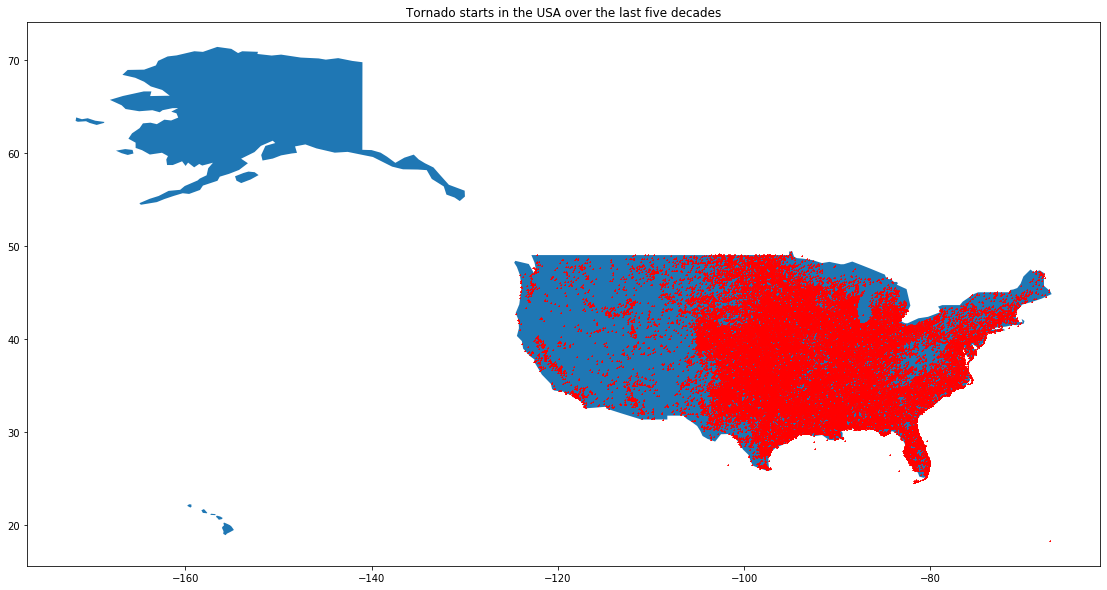

In [13]:
%%local

# Load map of the world
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#Isolate the map of the United States
usa_bis=world[world['iso_a3'] == 'USA']

#Plot the tornado start coordinates on this map

fig, ax = plt.subplots(figsize=(20, 10))

usa_bis.plot(ax=ax)
geo_tornado.plot(ax=ax, markersize=1, marker='+', color='red')

plt.title('Tornado starts in the USA over the last five decades')

#fig.savefig('map2.png')

Here we see more clearly that the tornados of the last five decades mostly started in the East part of the USA. Let's make some more elaborated visualisations to see where in particular tornados tend to start.

Therefore, let's plot a heat map and a density map per state to have a different perspective on the data.

<a id="heatmap"></a>
### b. Heatmap: identify the hotspots

Here we plot a heat map which shows that most tornados seem to start in *middle* part of the US, not just the *East* part of the country.

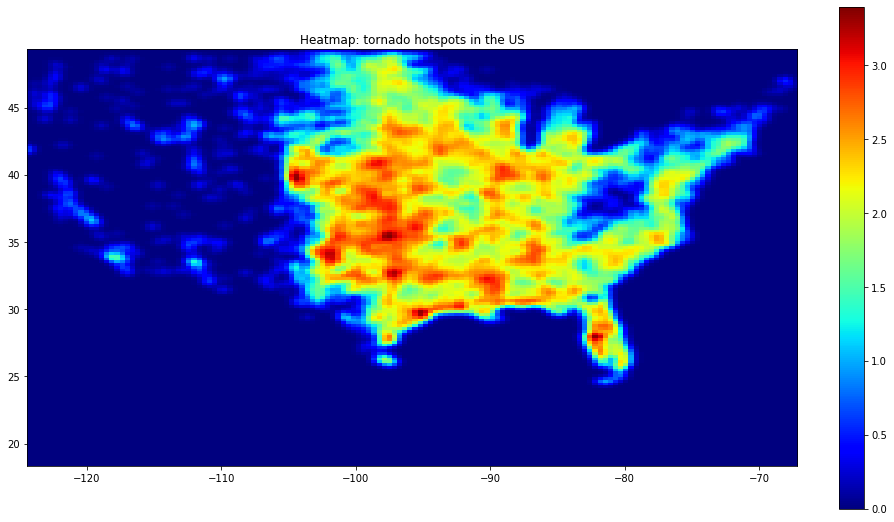

In [14]:
%%local

## Heatmap

# set size of the figure
pylab.rcParams['figure.figsize'] = 15, 12
# silence warnings
import warnings
warnings.filterwarnings("ignore")


def heatmap(d, grid=(150,150), smoothing=1, cmap='jet'):
    """
    Inputs
     * d: geodataframe containing Points
     * grid: how fine is the grid
     * smoothing: hyperparameter to obtain a smoothier image
     * cmap: colors
    Output
     * heat map (array displayed with matplotlib)    
    """
    
    longitude=list(d.SLON)
    latitude=list(d.SLAT)
    
    heatmap, xedges, yedges = np.histogram2d(latitude, longitude, bins=grid)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    fig, ax = plt.subplots()

    log_heatmap = np.log(heatmap)
    log_heatmap[np.isneginf(log_heatmap)] = 0
    log_heatmap = ndimage.filters.gaussian_filter(log_heatmap, smoothing, mode='nearest')
    
    plt.title('Heatmap: tornado hotspots in the US')
    plt.imshow(log_heatmap, cmap=cmap, extent=extent)
    plt.colorbar(fraction=0.03)
    plt.gca().invert_yaxis()
    plt.show()
    #fig.savefig('heatmap.png')

    
heatmap(geo_tornado)

A higher concentration of tornados is visible in the orange and red areas. Dark blue corresponds to no tornado at all. A kind of tornado corridor seems to go through the middle of the US, particularly in Colorado, Nebraska, Arkansas and Texas.

These official NOAA Tornado density maps corroborate with our previous visualisation. 

![title](http://www.spc.noaa.gov/wcm/2015-wbc-anoms.png)

Now let's count the number of tornados per state and plot the corresponding density map.

<a id="density_map"></a>
### c. Density map per state: where the risk hides

#### Tornados per state

In [15]:
%%local

# Count number of tornados per state 
# NB: here directly using pd dataframes because error for visualisations when using PySpark kernel  

states = geo_tornado.ST.unique().tolist()

count=[]
for name in states:
    count.append(geo_tornado[geo_tornado['ST']==name].shape[0])

state_count={'count':count}

# Examples :
print('__Examples__')
print('Number of tornados registered in :')
print(' - New Jersey: '+str(count[states.index('NJ')]))
print(' - Kentucky: '+str(count[states.index('KY')]))
print(' - Alabama: '+str(count[states.index('AL')]))
print(' - Texas: '+str(count[states.index('TX')]))

state_count_df = pd.DataFrame(state_count, index=states)

__Examples__
Number of tornados registered in :
 - New Jersey: 142
 - Kentucky: 857
 - Alabama: 1896
 - Texas: 8197


#### Load map of the United States
Here we load a different, more precise map, with geographical coordinates of each state in the country. Please follow these steps:
1. download  cb_2018_us_state_5m.zip with this link: https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_5m.zip 
2. Move it to your current working directory (the directory of this notebook)
3. Unzip it. Keep its content in the same directory where our notebook also is.

Note we will explicitly load only the .shp file but all files from the original .zip must be kept in the same directory as the .shp. Open the .shp file with his local path.

Data from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html 

In [16]:
%%local

## Load USA shape file for the coming visualisations
usa = geopandas.read_file("cb_2018_us_state_5m.shp")

## alternative path (remote)
# usa = geopandas.read_file("/mnt/bludata0/scratch/Tornado_demo/cb_2018_us_state_5m.shp")

#### Merge USA states map with per state tornado count

Let's create a new geodataframe as the concatenation of the frequency dataframe and the above USA geodataframe.

In [17]:
%%local

# Rename column 'state_name' in geodataframe usa
usa.rename(columns={'STUSPS':'state_name'}, inplace=True)
# Set column 'state_name' as index 
temp=usa.set_index('state_name')

# Concatenate and set index as 'state_name'
result = pd.concat([state_count_df, temp], axis=1, sort=True).reindex(state_count_df.index)
print(type(result)) # <class 'pandas.core.frame.DataFrame'>
# we must go back to a geodataframe

# Convert result into a geodataframe
geometry=result['geometry']
geo_result=geopandas.GeoDataFrame(result, geometry=geometry)
print(type(geo_result)) # <class 'geopandas.geodataframe.GeoDataFrame'>

<class 'pandas.core.frame.DataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


Note that Alaska and some islands will disappear from the map since we merged the datasets by using state_count_df to set the index, which do not contain a row for these regions.

#### Display tornado density per US state

Text(0.5, 1, 'Occurrences per state')

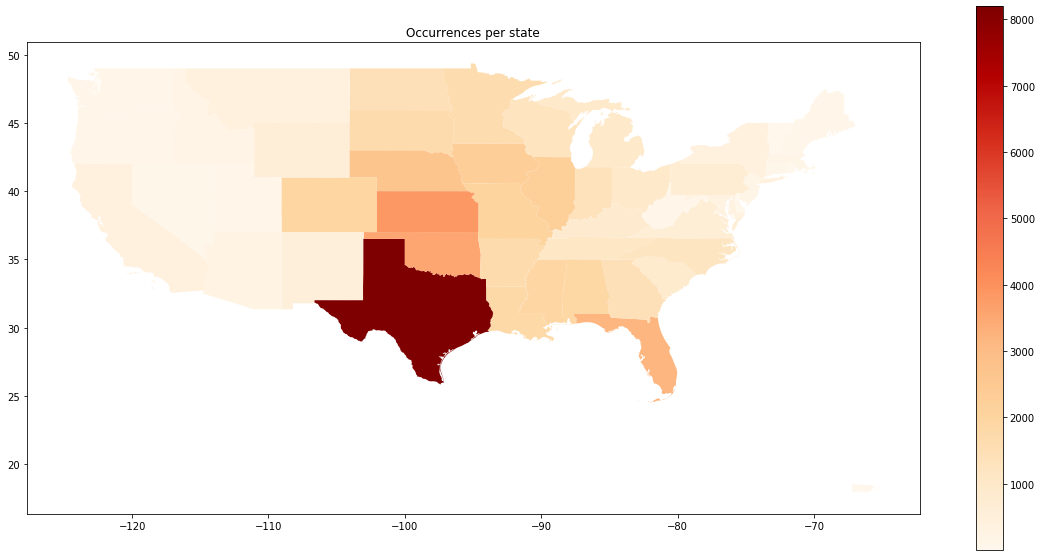

In [18]:
%%local

# Visualization 

fig, ax = plt.subplots(figsize=(20, 10))

geo_result.plot(column='count', ax=ax, legend=True, cmap='OrRd')

plt.title('Occurrences per state')

Well, now it's clear that Texas is the state which is the most tornado stricken of all states! It corroborates with the official maps above. We can now focus on this particular state.

## 4. Machine Learning: Tornado Clustering in Texas

From now on, we shall focus on Texas only. Let's use machine learning to cluster the hot spots for tornados within Texas. We use a classical K-means alorithm to compute the coordinates of tornado clusters within Texas.

Let's filter the tornado records corresponding to Texas and remember how many we have:

In [19]:
val input_texas = input.filter("ST = 'TX'")
input_texas.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

input_texas: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [OBJECTID: int, YR: string ... 11 more fields]
res22: Long = 8197


We want to assign each insurance policy holder for real estate in Texas to a tornado cluster in Texas in order to caclulate a risk score. Elaborated risk scores can be defined according to the caracteristics of each cluster and the distance of the property from all clusters.

<a id="clusters_texas"></a>
### a. Build tornado clusters in Texas
Let's compute and plot the tornado clusters within Texas.

#### Training

First we define the feature selection stage of the Spark ML pipeline. We train based on Tornado latitude and logitude.

In [20]:
val assembler = new VectorAssembler().
            setInputCols(Array("SLAT", "SLON")).
            setOutputCol("features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

assembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_29d25b05b571


Now we define the model training stage for unsupervised cluster training using KMeans algorithm from Spark ML API. You can change the number of iterations as well as the number of cluster centers that should be detected. For demonstration purposes, the seed is specified for the cluster centers to start at the same point.

In [21]:
// # Set model parameters
val clustering = new KMeans().
            setFeaturesCol("features").
            setK(5).
            setMaxIter(5).
            setSeed(123)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

clustering: org.apache.spark.ml.clustering.KMeans = kmeans_49c826cdb5d7


Now we stitch together the ML pipeline with feature selection and training stages:

In [22]:
val pipe = new Pipeline().setStages(Array(assembler, clustering))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pipe: org.apache.spark.ml.Pipeline = pipeline_5d4bacf1e9fc


Now run the ML pipeline on the input data of Texas tornados:

In [23]:
val model = pipe.fit(input_texas)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

model: org.apache.spark.ml.PipelineModel = pipeline_5d4bacf1e9fc


This ran quick. If you want to observe a longer model training run, execute the following cell:

In [24]:
var input_ballooned = input.unionAll(input).unionAll(input).unionAll(input).unionAll(input).unionAll(input).unionAll(input)
pipe.fit(input_ballooned)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

input_ballooned: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [OBJECTID: int, YR: string ... 11 more fields]
res24: org.apache.spark.ml.PipelineModel = pipeline_5d4bacf1e9fc


Let's explore the trained model and print out the detected cluster centers with their latitude and longitude:

In [25]:
//NOT-FOR-APP
val clustercenters = model.stages(1).asInstanceOf[KMeansModel].clusterCenters
val clustercentersschema = StructType(for (i <- 1 to clustercenters.head.size) yield StructField(s"col$i", DoubleType, false))
val clustercentersconverted = clustercenters.map { x: Vector => Row.fromSeq(x.toArray) }
val clustercentersdataframe = spark.createDataFrame(sc.parallelize(clustercentersconverted), clustercentersschema).toDF("SLAT", "SLON")
clustercentersdataframe.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

clustercenters: Array[org.apache.spark.ml.linalg.Vector] = Array([32.589628601252606,-99.32586040361865], [32.424699301397204,-95.9672249001996], [31.5663856545961,-102.24588022284125], [29.220166621376805,-96.65417509057973], [34.76257306010928,-101.56258360655737])
clustercentersschema: org.apache.spark.sql.types.StructType = StructType(StructField(col1,DoubleType,false), StructField(col2,DoubleType,false))
clustercentersconverted: Array[org.apache.spark.sql.Row] = Array([32.589628601252606,-99.32586040361865], [32.424699301397204,-95.9672249001996], [31.5663856545961,-102.24588022284125], [29.220166621376805,-96.65417509057973], [34.76257306010928,-101.56258360655737])
clustercentersdataframe: org.apache.spark.sql.DataFrame = [SLAT: double, SLON: double]
+------------------+-------------------+
|              SLAT|               SLON|
+------------------+-------------------+
|32.589628601252606| -99.32586040361865|
|32.424699301397204|  -95.9672249001996|
|  31.5663856545961|-102.24

In [26]:
//ADDED

val predictions_texas = model.transform(input_texas)
val op_texas=predictions_texas.select("OBJECTID","SLON","SLAT","prediction")

val tornados_with_clusters_texas = op_texas.toDF("OBJECTID","SLON","SLAT","ClusterId")
val count_texas=tornados_with_clusters_texas.groupBy("ClusterId").count().orderBy("ClusterID")
count_texas.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

predictions_texas: org.apache.spark.sql.DataFrame = [OBJECTID: int, YR: string ... 13 more fields]
op_texas: org.apache.spark.sql.DataFrame = [OBJECTID: int, SLON: double ... 2 more fields]
tornados_with_clusters_texas: org.apache.spark.sql.DataFrame = [OBJECTID: int, SLON: double ... 2 more fields]
count_texas: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [ClusterId: int, count: bigint]
+---------+-----+
|ClusterId|count|
+---------+-----+
|        0| 1481|
|        1| 1951|
|        2|  751|
|        3| 2191|
|        4| 1823|
+---------+-----+



In [27]:
count_texas.createOrReplaceTempView("count_texas")
clustercentersdataframe.createOrReplaceTempView("texas_clusters")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
%%sql -o count_texas --maxrows -1
SELECT * FROM count_texas

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [29]:
%%sql -o texas_clusters -n -1 
SELECT * FROM texas_clusters

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [30]:
%local

texas_cluster_count=pd.DataFrame()
texas_cluster_count["ClusterId"]=count_texas["ClusterId"]
texas_cluster_count["longitude"]=texas_clusters["SLON"]
texas_cluster_count["latitude"]=texas_clusters["SLAT"]
texas_cluster_count["count"]=count_texas["count"]

texas_cluster_count

Output()

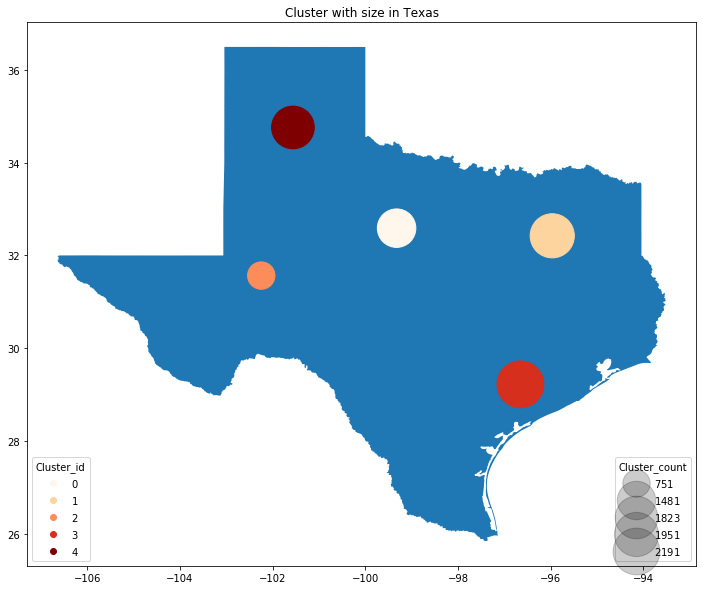

In [31]:
%local

## to modify : visualize the scope of each cluster and add more significant bubble size (has to be easy to see)

lon_lat=[Point(x, y) for x, y in zip(texas_cluster_count.longitude, texas_cluster_count.latitude)]
geo_cluster=geopandas.GeoDataFrame(texas_cluster_count, geometry=lon_lat)

# Isolate Texas map

texas=usa.loc[usa["NAME"] == "Texas"]

# Plot 

x, y = texas_cluster_count.longitude, texas_cluster_count.latitude
c = texas_cluster_count.index
s = texas_cluster_count["count"]

fig, ax = plt.subplots(figsize=(20,10))

texas.plot(ax=ax)

scatter = ax.scatter(x, y, c=c, s=s, cmap="OrRd")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster_id")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.2)
legend2 = ax.legend(handles, labels, loc="lower right", title="Cluster_count")


plt.title("Cluster with size in Texas")
plt.show()

Here we can see in which parts of Texas tornados seem to be concentrated. The size of each bullet indicates the number of tonados belonging to the cluster. 
(But a cluster center is not all. What about the shape of the clusters? Their actual surface ? Let's visualize it. -> to add)

<a id="insurance_holders"></a>
### b. Assess risk of home insurance holders in Texas

#### Load the insurance holders data

Note that this data is made up for the sake of this demo.

We want to assign each holder of an insurance policies for real estate in Texas to one of the tornado clusters in order to caclulate a risk score according to which cluster his property belongs to.

In [32]:
var insurance_holders = spark.read.
   format("com.ibm.idax.spark.idaxsource").
   option("dbtable", "TEXAS_CUSTOMERS").
   load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

insurance_holders: org.apache.spark.sql.DataFrame = [OBJECTID: int, NAME: string ... 3 more fields]


Again run the following cell only when you are on a dashDB SMP system to get a partitioned data frame:

In [33]:
insurance_holders = insurance_holders.repartition(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

insurance_holders: org.apache.spark.sql.DataFrame = [OBJECTID: int, NAME: string ... 3 more fields]


Now let's take a look at the insurance holder data:

In [34]:
//NOT-FOR-APP
var insurance_holders_sample = insurance_holders.sample(false,0.05)
insurance_holders.show(5)
insurance_holders.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

insurance_holders_sample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [OBJECTID: int, NAME: string ... 3 more fields]
+--------+----------------+---------------+-------------------+------------------+
|OBJECTID|            NAME|INSURANCE_VALUE|                LON|               LAT|
+--------+----------------+---------------+-------------------+------------------+
|  117802|      Rene Deeds|         129160|-100.97351172048946|36.483356123686235|
|  975035|  Margarite Aman|         870576| -95.94546228235839|   32.896969427697|
|   50147|Marissa Tetrault|         209170| -103.0397886657143|31.819902347115658|
|  799031| Floretta Parlin|         261638|-104.90986339707808|30.704859819325236|
|  243795|  Marcela Howery|         394092|-102.34002085138115|33.113241633594555|
|  909173|    Luanna Meier|         939400|-100.94431212400531| 35.54398328290222|
|   32922|  Sheilah Sumler|         297791| -96.90261198875226| 33.64999840939913|
|  908983|        Jo Lloyd|         145

Let's visualize a sample of the Texas insurance holders on a map:

In [35]:
insurance_holders.createOrReplaceTempView("insurance_holders")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
%%sql -o insurance_holders -n -1
SELECT * FROM insurance_holders

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

#### Display: Customers and clusters 
In grey, you can see where insurance holders are located.

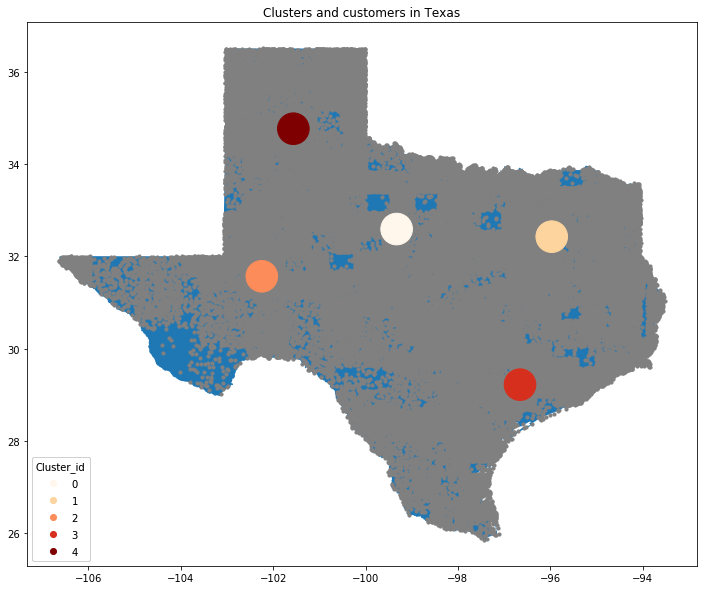

In [37]:
%%local

# Let's make geopoints out of this new data
lon_lat=[Point(x, y) for x, y in zip(insurance_holders.LON, insurance_holders.LAT)]
insurance_holders=geopandas.GeoDataFrame(insurance_holders, geometry=lon_lat)

# Let's plot it 

fig, ax = plt.subplots(figsize=(20,10))
x, y = texas_cluster_count.longitude, texas_cluster_count.latitude
c = texas_cluster_count.index


texas.plot(ax=ax) # map
insurance_holders.plot(ax=ax, markersize=10, color="grey") # insurance holders
scatter = ax.scatter(x, y, c=c, s=1000, cmap="OrRd") # clusters 

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster_id")
ax.add_artist(legend1)

plt.title("Clusters and customers in Texas")

plt.show()

#### Assign customers to their nearest tornado cluster

Finally, we run a prediction with the tornado cluster model on the insurance holders to assign each one to its nearest tornado cluster. We then print a sample of the result.


In [38]:
val insurance_holders_renamed = insurance_holders.toDF(Seq("OBJECTID", "NAME", "INSURANCE_VALUE", "SLON", "SLAT"): _*)
var insurance_holders_scored = model.transform(insurance_holders_renamed).select("OBJECTID", "NAME", "INSURANCE_VALUE", "SLON","SLAT","prediction")
insurance_holders_scored = insurance_holders_scored.toDF(Seq("OBJECTID", "NAME", "INSURANCE_VALUE", "SLON", "SLAT", "ClusterID"): _*)

insurance_holders_scored.show(10)
//insurance_holders_scored.groupBy("ClusterID").count().show()

println("Writing results to table TEXAS_CUSTOMERS_SCORED ...")
insurance_holders_scored.write.format("com.ibm.idax.spark.idaxsource").
   option("dbtable", "TEXAS_CUSTOMERS_SCORED").
   mode(SaveMode.Overwrite).
   save()
println("Done")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

insurance_holders_renamed: org.apache.spark.sql.DataFrame = [OBJECTID: int, NAME: string ... 3 more fields]
insurance_holders_scored: org.apache.spark.sql.DataFrame = [OBJECTID: int, NAME: string ... 4 more fields]
insurance_holders_scored: org.apache.spark.sql.DataFrame = [OBJECTID: int, NAME: string ... 4 more fields]
+--------+----------------+---------------+-------------------+------------------+---------+
|OBJECTID|            NAME|INSURANCE_VALUE|               SLON|              SLAT|ClusterID|
+--------+----------------+---------------+-------------------+------------------+---------+
|  117802|      Rene Deeds|         129160|-100.97351172048946|36.483356123686235|        4|
|  975035|  Margarite Aman|         870576| -95.94546228235839|   32.896969427697|        1|
|   50147|Marissa Tetrault|         209170| -103.0397886657143|31.819902347115658|        2|
|  799031| Floretta Parlin|         261638|-104.90986339707808|30.704859819325236|        2|
|  243795|  Marcela Howery|

The resulting cluster ID determines the risk class that the insurance holder will be assigned to. In addition we could run a fine tuning for the risk assignment by folding in the distance from the insured property to the cluster center.

Let's colorize the sampled Texas insurance holders according to their assigned cluster:

In [39]:
//NOT-FOR-APP - if you want to siplay only a sample of the data
var insurance_holders_scored_sample = insurance_holders_scored.sample(false, 0.05)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

insurance_holders_scored_sample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [OBJECTID: int, NAME: string ... 4 more fields]


In [40]:
insurance_holders_scored.createOrReplaceTempView("insurance_holders")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
%%sql -o insurance_holders -n -1
SELECT * FROM insurance_holders

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

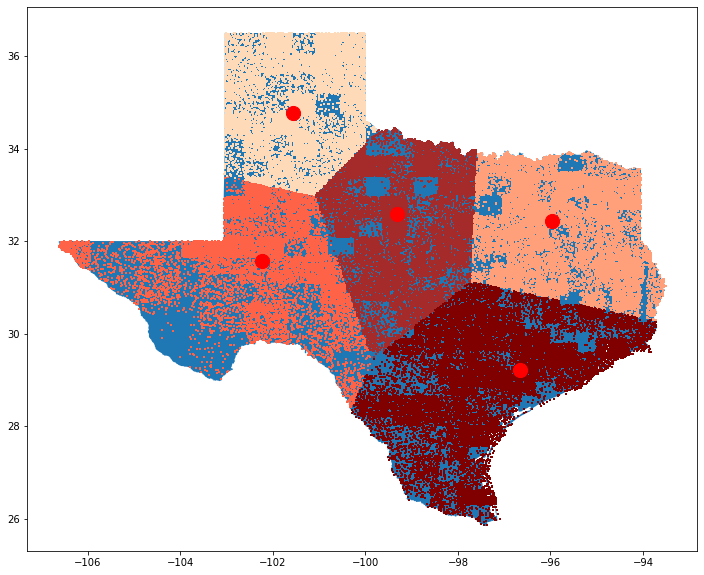

In [42]:
%%local

# Plot with color code

fig, ax = plt.subplots(figsize=(20,10))
texas.plot(ax=ax)

# GeoDataFrame
lon_lat=[Point(x, y) for x, y in zip(insurance_holders.SLON, insurance_holders.SLAT)]
insurance_holders=geopandas.GeoDataFrame(insurance_holders, geometry=lon_lat)


# isolate each group and plot it with a different graphic code
colors=['brown','lightsalmon', 'tomato', 'maroon', 'peachpuff', 'indianred', 'mistyrose', 'seeshell', 'linen'][:len(texas_cluster_count)]
for i in range(len(texas_clusters)):
    insurance_holders[insurance_holders['ClusterID']==i].plot(ax=ax, markersize=5, marker='+', color=colors[i])

# Cluster centers
texas_clusters=geopandas.GeoDataFrame(texas_cluster_count, geometry=[Point(x, y) for x, y in zip(texas_cluster_count.longitude, texas_cluster_count.latitude)])
texas_clusters.plot(ax=ax, markersize=200, marker='o', color='red')

#### Visualise the price paid by each household 
Could be a development of this use case... Your turn to code! 
1. define rule of insurance policy
2. apply rule on your data
3. visualize

## 5. Deploy your application with your own data
You can easily deploy the essential logic of this notebook as an application that can be run at any time via a dashDB [stored procedure](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_spark_applications_functions.html) invokation, via dashDB's command line [spark-submit.sh](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.doc/learn_how/spark_ref.html) or via a [REST API](https://developer.ibm.com/clouddataservices/wp-content/themes/projectnext-clouddata/dashDBanalytics/#/).

Note that a few cells above have the __`//NOT-FOR-APP`__ comment. Cells with this comment as well as cells that only contain Jupyter cell magic starting with __`%%`__ are automatically skipped when deploying the notebook as an application. This way you can organize your notebook for interactive vs. backend logic.

In order to generate and deploy an application for this notebook select __`File->Deploy as->Deploy to dashDB Spark`__ in the menu above. After a short while it shows you the result page for the deployment with the specific invocation options that you just can copy and past to try them out immediately.

## What you've learned

Congratulations! 

You've successfully learned how to:
* connect to Db2 and launch a Spark session through livy
* add or retrieve data from Db2, anytime and anywhere
* analyze data with Spark, using Scala and Python
* create a temporary view of a Spark dataframe
* visualize geographic data locally using matplotlib and geopandas for risk assessment

You can now easily deploy your own application and run it anytime on IBM Db2!

___
## Authors

__Eva Feillet__ is intern at IBM Research Lab in Böblingen. She comes from CentraleSupelec Engineering School in France and has studied deep learning at the Technical University of Munich. She is passionnate about data science and eager to apply it to real-life use cases.

__Toni Bollinger__

Copyright © 2019 IBM Corporation. All rights reserved.